# Large Factor Modelling
This is an extension to the DSE4212 project. 

We apply Maximum Sharpe Ratio Regression (MSRR) to estimate the Stochastic Discount Factor, which provides optimal portfolio returns.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import riskfolio as rf

# Define stock tickers and factor ETFs
TEST_SET = ["AAPL", "CVX", "GS", "JNJ", "JPM", "MSFT", "PFE", "PG", "GOOG", "XOM"]
factor_etfs = ["SPYG", "SPYV", "IWF", "IWD", "IWM", "IWN", "IWO", "SPLV", "SPHB", "MTUM", 
               "QUAL", "VLUE", "SIZE", "USMV", "DIA", "QQQ", "VTV", "VUG", "VOE", "VBR"]

# Define train and test periods
train_start = '2014-01-02'
train_end = '2022-12-30'
test_start = '2023-01-03'
test_end = '2024-10-18'

# Step 1: Download Factor Data and Compute Returns
factor_data = (
    yf.download(factor_etfs, start=train_start, end=test_end)["Adj Close"]
    .pct_change()
    .dropna()
)

# Step 2: Download Stock Data and Compute Returns
stock_data = (
    yf.download(TEST_SET, start=train_start, end=test_end)["Adj Close"]
    .pct_change()
    .dropna()
)

# Step 3: Split into Train and Test Sets
factor_train = factor_data.loc[train_start:train_end]
factor_test = factor_data.loc[test_start:test_end]

stock_train = stock_data.loc[train_start:train_end]
stock_test = stock_data.loc[test_start:test_end]

# Step 4: Align Dates Between Stock and Factor Data
common_dates_train = factor_train.index.intersection(stock_train.index)
factor_train = factor_train.loc[common_dates_train]
stock_train = stock_train.loc[common_dates_train]

common_dates_test = factor_test.index.intersection(stock_test.index)
factor_test = factor_test.loc[common_dates_test]
stock_test = stock_test.loc[common_dates_test]


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  10 of 10 completed


Initial portfolio value: 100000.00
Final portfolio value: 145439.41
Final accumulative portfolio return: 1.4544
Maximum DrawDown: -0.0985
Sharpe ratio: 0.1004


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1187610671.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_portfolio_value = final_portfolio_value[0]
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1187610671.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown.min()[0]
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1187610671.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

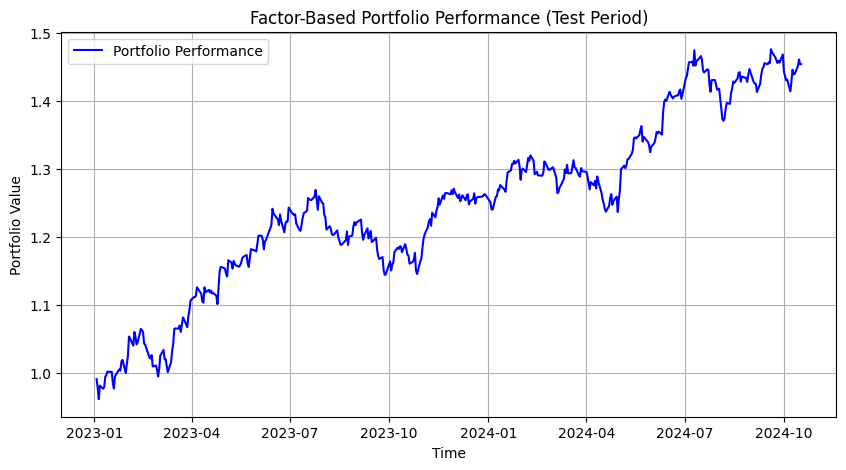

In [27]:

# Step 5: Train Portfolio Model on Training Data
portfolio = rf.Portfolio(returns=stock_train)
portfolio.assets_stats(method_mu="hist", method_cov="ledoit")

# # Step 6: Perform Principal Component Regression (PCR) for Factor Selection
# factor_loadings = rf.loadings_matrix(
#     X=factor_train,
#     Y=stock_train, 
#     feature_selection="PCR",
#     n_components=0.95
# )

# Step 7: Assign Factors and Optimize Portfolio Weights
portfolio.factors = factor_train
portfolio.factors_stats(
    method_mu="hist",
    method_cov="ledoit",
    dict_load= {'feature_selection': 'PCR', 'n_components': 0.95}
)

# Step 8: Optimize Portfolio Weights (Training Phase)
optimal_weights = portfolio.optimization(
    model="FM",  # Factor Model Optimization
    rm="MV",     # Mean-Variance Optimization
    obj="Sharpe",  # Maximize Sharpe Ratio
    hist=False
)

# Step 9: Apply Weights to Test Data for Portfolio Performance Evaluation
portfolio_returns_test = stock_test @ optimal_weights  # Compute portfolio returns

# Step 10: Compute Portfolio Performance Metrics
initial_portfolio_value = 100000
portfolio_cumulative_returns = (1 + portfolio_returns_test).cumprod()
final_portfolio_value = initial_portfolio_value * portfolio_cumulative_returns.iloc[-1]
final_portfolio_value = final_portfolio_value[0]

# Compute Maximum Drawdown
rolling_max = portfolio_cumulative_returns.cummax()
drawdown = portfolio_cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()[0]

# Compute Sharpe Ratio
sharpe_ratio = portfolio_returns_test.mean()[0] / portfolio_returns_test.std()[0]

# Step 11: Print Performance Metrics
print("=================================")
print(f"Initial portfolio value: {initial_portfolio_value:.2f}")
print(f"Final portfolio value: {final_portfolio_value:.2f}")
print(f"Final accumulative portfolio return: {final_portfolio_value / initial_portfolio_value:.4f}")
print(f"Maximum DrawDown: {max_drawdown:.4f}")
print(f"Sharpe ratio: {sharpe_ratio:.4f}")
print("=================================")

# Step 12: Plot Portfolio Performance
plt.figure(figsize=(10, 5))
plt.plot(portfolio_cumulative_returns, label="Portfolio Performance", color='blue')
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Factor-Based Portfolio Performance (Test Period)")
plt.legend()
plt.grid()
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import riskfolio as rf
from tqdm import tqdm  # For progress tracking

# Define stock tickers and factor ETFs
TEST_SET = ["AAPL", "CVX", "GS", "JNJ", "JPM", "MSFT", "PFE", "PG", "GOOG", "XOM"]
factor_etfs = ["SPYG", "SPYV", "IWF", "IWD", "IWM", "IWN", "IWO", "SPLV", "SPHB", "MTUM", 
               "QUAL", "VLUE", "SIZE", "USMV", "DIA", "QQQ", "VTV", "VUG", "VOE", "VBR"]

# Define date range for rolling training/testing
train_window = 756  # 3 years of training (252 trading days per year)
test_start = '2023-01-03'
test_end = '2024-10-18'

# Step 1: Download Factor Data and Compute Returns
factor_data = (
    yf.download(factor_etfs, start='2014-01-02', end=test_end)["Adj Close"]
    .pct_change()
    .dropna()
)

# Step 2: Download Stock Data and Compute Returns
stock_data = (
    yf.download(TEST_SET, start='2014-01-02', end=test_end)["Adj Close"]
    .pct_change()
    .dropna()
)

# Step 3: Align Dates Between Stock and Factor Data
common_dates = factor_data.index.intersection(stock_data.index)
factor_data = factor_data.loc[common_dates]
stock_data = stock_data.loc[common_dates]

# Step 4: Initialize variables for rolling window optimization
initial_portfolio_value = 100000
portfolio_value = initial_portfolio_value
portfolio_values = []  # Store daily portfolio value
weights_history = []  # Store weight allocations
sharpe_ratios = []  # Track Sharpe ratio changes

# Step 5: Rolling Window Optimization (Daily Rebalancing)
test_dates = stock_data.loc[test_start:test_end].index

for current_date in tqdm(test_dates, desc="Rebalancing Portfolio Daily"):
    # Define rolling training window (use last 3 years of data)
    train_end_idx = stock_data.index.get_loc(current_date) - 1
    train_start_idx = max(0, train_end_idx - train_window)
    
    stock_train = stock_data.iloc[train_start_idx:train_end_idx]
    factor_train = factor_data.iloc[train_start_idx:train_end_idx]

    # Train portfolio optimization model
    portfolio = rf.Portfolio(returns=stock_train)
    portfolio.assets_stats(method_mu="hist", method_cov="ledoit")

    # Assign Factors and Optimize Portfolio Weights
    portfolio.factors = factor_train
    portfolio.factors_stats(
        method_mu="hist",
        method_cov="ledoit",
        dict_load= {'feature_selection': 'PCR', 'n_components': 0.95}
    )

    # Optimize Portfolio Weights (Daily)
    optimal_weights = portfolio.optimization(
        model="FM",  # Factor Model Optimization
        rm="MV",     # Mean-Variance Optimization
        obj="Sharpe",  # Maximize Sharpe Ratio
        hist=False
    )

    # Save weights for tracking
    weights_history.append(optimal_weights)

    # Apply the current day's weights to the next day's returns (if available)
    if current_date in stock_data.index:
        next_day_return = stock_data.loc[current_date]  # Get next day's stock return
        daily_portfolio_return = np.dot(optimal_weights.T, next_day_return.fillna(0))  # Compute weighted return
        
        # Update portfolio value
        portfolio_value *= (1 + daily_portfolio_return)
        portfolio_values.append(portfolio_value)

        # Compute rolling Sharpe ratio (using available test data so far)
        if len(portfolio_values) > 1:
            sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values)
            sharpe_ratios.append(sharpe_ratio)



[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  10 of 10 completed
Rebalancing Portfolio Daily:   0%|          | 0/451 [00:00<?, ?it/s]/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1347179554.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values)
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1347179554.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values)
Rebalancing Portfolio Daily:   1%|          | 3/451 [00:00<00:21, 21.24it/s]/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1347179554.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values)
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28708/1347179554

Initial portfolio value: 100000.00
Final portfolio value: 116205.89
Final accumulative portfolio return: 1.1621
Maximum DrawDown: 0.0000
Sharpe ratio: 7985608055774546.0000


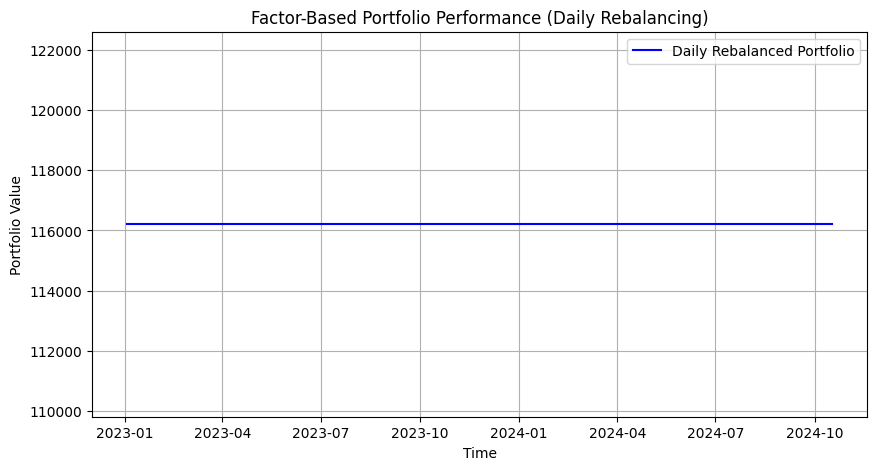

In [33]:
# Step 6: Compute Final Performance Metrics
final_portfolio_value = portfolio_values[-1]
final_portfolio_value = final_portfolio_value[0]
cumulative_return = final_portfolio_value / initial_portfolio_value

# Compute Maximum Drawdown
portfolio_series = pd.Series(portfolio_values, index=test_dates)
rolling_max = portfolio_series.cummax()
drawdown = portfolio_series / rolling_max - 1
max_drawdown = drawdown.min()[0]

# Compute Final Sharpe Ratio
final_sharpe_ratio = np.mean(portfolio_values) / np.std(portfolio_values)

# Step 7: Print Performance Metrics
print("=================================")
print(f"Initial portfolio value: {initial_portfolio_value:.2f}")
print(f"Final portfolio value: {final_portfolio_value:.2f}")
print(f"Final accumulative portfolio return: {cumulative_return:.4f}")
print(f"Maximum DrawDown: {max_drawdown:.4f}")
print(f"Sharpe ratio: {final_sharpe_ratio:.4f}")
print("=================================")

# Step 8: Plot Portfolio Performance
plt.figure(figsize=(10, 5))
plt.plot(portfolio_series, label="Daily Rebalanced Portfolio", color='blue')
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Factor-Based Portfolio Performance (Daily Rebalancing)")
plt.legend()
plt.grid()
plt.show()
